In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import scipy as sp
from detection import eddyDetection
import ast
from tqdm import tqdm
from detection import full_inner_eddy_region_v2
from IPython.display import Video, display
from animation import animation_local_gif
from PIL import Image
import IPython.display as ipy_display
import ipywidgets as widgets

In [2]:
df = xr.open_dataset('C:/Users/eirik/Master/Data/new_dataset.nc')
df_eta = xr.open_dataset('C:/Users/eirik/Master/Data/Eta.nc')
hor_vel = xr.open_dataset('C:/Users/eirik/Master/Data/Horizontal_hor_vel.nc')['hor_vel']

In [3]:
# Inner domain
domain_center = [[-20,0],[72,73]]
OW_center = df['Okubo_Weiss']*(1/(10**(-9)))
eta_center = df_eta['Eta']
OW_center = OW_center.sel(X=slice(domain_center[0][0],domain_center[0][1]))
OW_center = OW_center.sel(Y=slice(domain_center[1][0],domain_center[1][1]))
OW_center = OW_center.sel(Z=-1)
eta_center = eta_center.sel(X=slice(domain_center[0][0],domain_center[0][1]))
eta_center = eta_center.sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta['Eta']
eta = eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2))
eta = eta.sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2))

# Resample data
eta = eta.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
hor_vel = hor_vel.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-01-01T00:00:00.000000000','2018-01-10T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))

hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

# Running algorythm for eddy center location

In [4]:
# Set True to run, or read previously file made
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False
if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(eddyDetection(eta_center[i],OW_center[i]))
        print('Processing: ',100*(i+1)/len(eta_center), '%')
    with open("eddyCenterpoints_test.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Loading previously saved eddy centerpoints###


# Running algorythm to find inner eddy region

In [5]:
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False

if run:
    eddy_centers = eddyLocation
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    for time in range(len(eddyLocation)):
        # First run per time step
        
        
        eddyDataset = full_inner_eddy_region_v2(eta=eta[time],eddy_center=eddy_centers[time][0][0],warm=True,eddiesDataset=eddies[time])
        
        for i in range(1,len(eddy_centers[time][0])):
            eddyDataset = full_inner_eddy_region_v2(eta=eta[time],eddy_center=eddy_centers[time][0][i],warm=True,eddiesDataset=eddyDataset)
            
        for i in range(0,len(eddy_centers[time][1])):
            eddyDataset = full_inner_eddy_region_v2(eta=eta[time],eddy_center=eddy_centers[time][1][i],cold=True,eddiesDataset=eddyDataset)
        
        pbar.update(1)
        eddies[time] = eddyDataset
    eddies.to_netcdf('C:/Users/eirik/Master/Data/EddiesTest.nc')
else:
    eddies = xr.open_dataset('C:/Users/eirik/Master/Data/EddiesTest.nc')
    eddies = eddies['EddyDetection']

Running algorythm:  20%|██        | 2/10 [00:48<03:15, 24.38s/it]

Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  30%|███       | 3/10 [01:18<03:09, 27.06s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  40%|████      | 4/10 [01:47<02:44, 27.44s/it]

Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  50%|█████     | 5/10 [02:11<02:12, 26.41s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  60%|██████    | 6/10 [02:34<01:40, 25.16s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  80%|████████  | 8/10 [03:27<00:51, 25.82s/it]

Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  90%|█████████ | 9/10 [03:49<00:24, 24.71s/it]

Error in X domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc


Running algorythm: 100%|██████████| 10/10 [04:05<00:00, 22.00s/it]

In [6]:
# df_depth = xr.open_dataset('C:/Users/eirik/Master/Data/depth.nc')
# depth = df_depth['Depth'].sel(X=slice(eddies.X[0], eddies.X[-1])).sel(Y=slice(eddies.Y[0], eddies.Y[-1]))

# from IPython.display import Image, display
# # animation_local_gif(data=eddies,name='Eddies_025DTest',unit='No eddy, Warm eddy, Cold eddy',depth=depth,interval=150)
# display(Image('Eddies_025DTest.gif'))

In [7]:
# df_depth = xr.open_dataset('C:/Users/eirik/Master/Data/depth.nc')
# depth = df_depth['Depth'].sel(X=slice(eddies.X[0], eddies.X[-1])).sel(Y=slice(eddies.Y[0], eddies.Y[-1]))

# from IPython.display import Image, display
# # animation_local_gif(data=eddies,name='Eddies_1DTest',unit='No eddy, Warm eddy, Cold eddy',depth=depth,interval=200)
# display(Image('Eddies_1DTest.gif'))

# Testing out eddy outer region detection

In [8]:
from detection import outer_eddy_region

eddies_full = eddies.copy()

for time in range(len(eddies_full.time)):
    data = outer_eddy_region(hor_vel=hor_vel[time],eddiesDataset=eddies_full[time])
    print('Progress: ',100*(time+1)/len(eddies.time))
    data = data.where(data != 0, np.nan)
    eddies_full[time] = data


Running outer region algorythm: 100%|██████████| 231/231 [01:20<00:00,  2.88it/s]


Progress:  10.0


Running outer region algorythm: 100%|██████████| 231/231 [01:18<00:00,  2.94it/s]


Progress:  20.0


Running outer region algorythm: 100%|██████████| 231/231 [01:18<00:00,  2.95it/s]


Progress:  30.0


Running outer region algorythm: 100%|██████████| 231/231 [01:19<00:00,  2.92it/s]


Progress:  40.0


Running outer region algorythm: 100%|██████████| 231/231 [01:18<00:00,  2.93it/s]


Progress:  50.0


Running outer region algorythm: 100%|██████████| 231/231 [01:20<00:00,  2.87it/s]


Progress:  60.0


Running outer region algorythm: 100%|██████████| 231/231 [01:24<00:00,  2.72it/s]


Progress:  70.0


Running outer region algorythm: 100%|██████████| 231/231 [01:13<00:00,  3.14it/s]


Progress:  80.0


Running outer region algorythm: 100%|██████████| 231/231 [01:13<00:00,  3.12it/s]


Progress:  90.0


Running outer region algorythm: 100%|██████████| 231/231 [01:15<00:00,  3.04it/s]

Progress:  100.0


In [9]:
# print(eddies_full.max().values)
# display(hor_vel[0].max() > 0.7)

# display(eddies[0][-10+11:10+11,-10+11:10+11].max())

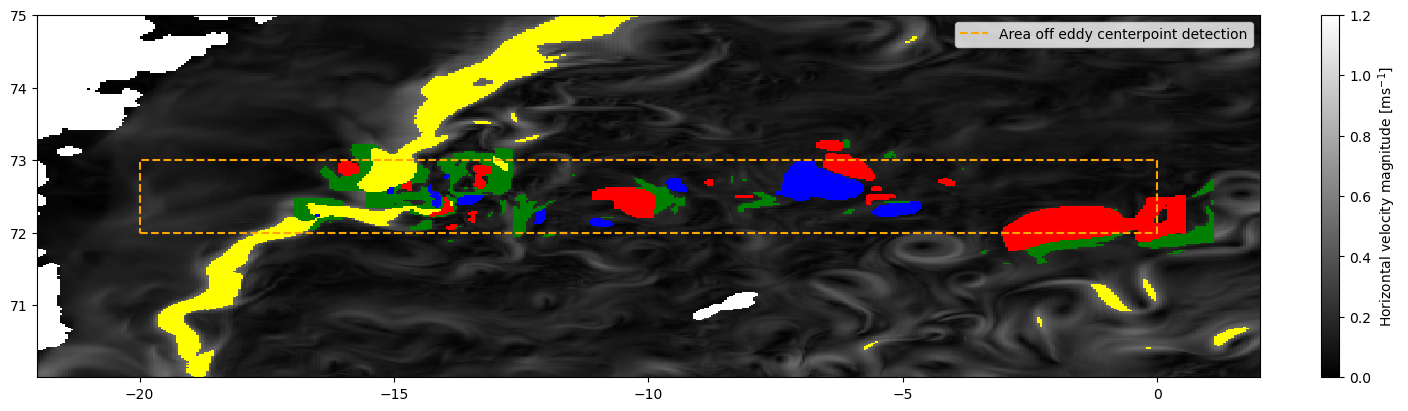

In [18]:
# 1 = warm, 2 = cold, 3 = current, 4 = stream
import matplotlib.colors as mcolors

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(14,4),layout='constrained')
mesh = ax.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],vmin=0,vmax=1.2,cmap='binary_r')
cbar = fig.colorbar(mesh)
cbar.set_label('Horizontal velocity magnitude [ms$^{-1}$]')
ax.pcolormesh(eddies_full.X,eddies_full.Y,eddies_full[0],cmap=cmap, norm=norm)
x = [-20,0,0,-20,-20]
y = [72,72,73,73,72]
ax.plot(x,y,color='orange',linestyle='--', label='Area off eddy centerpoint detection')
ax.legend()


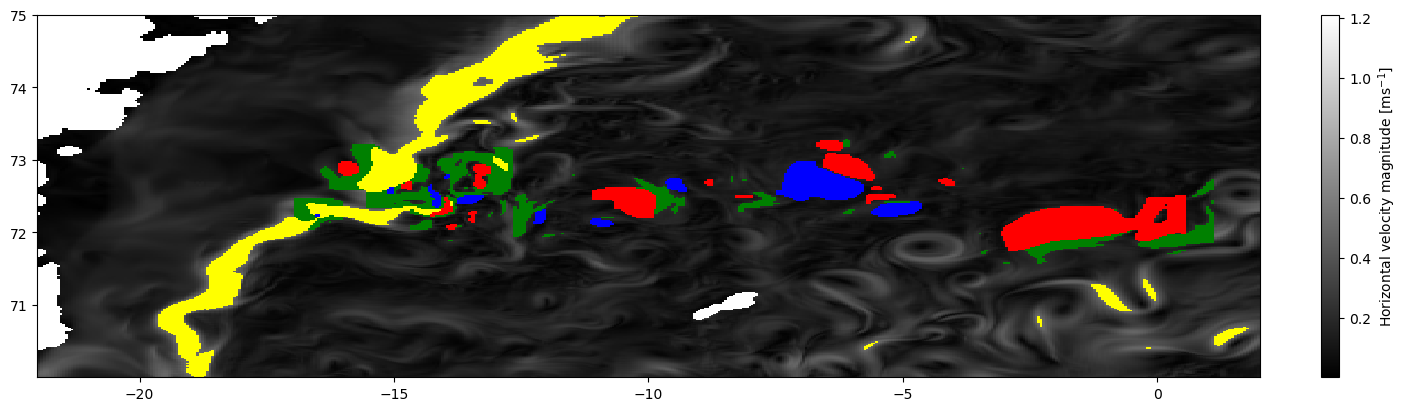

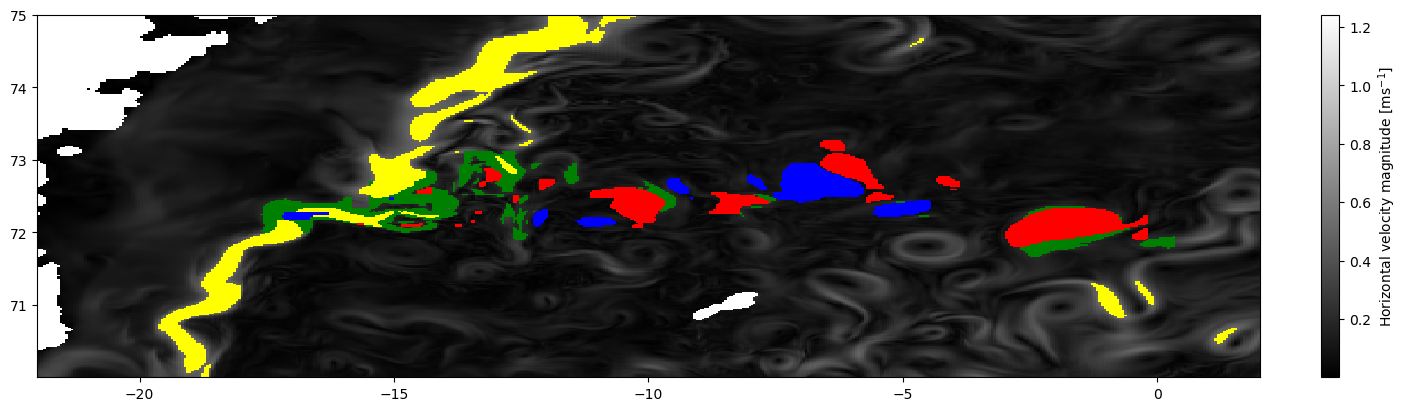

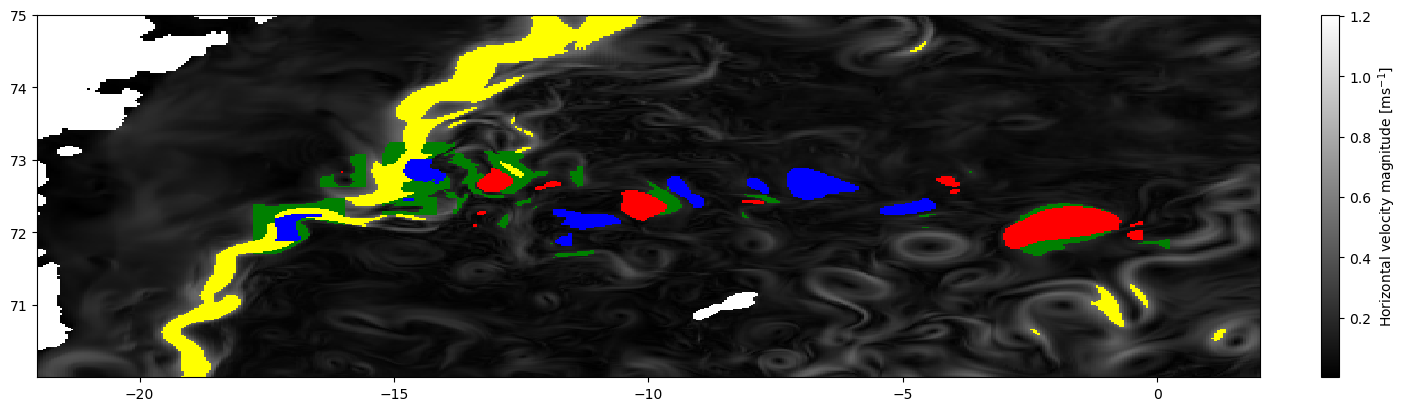

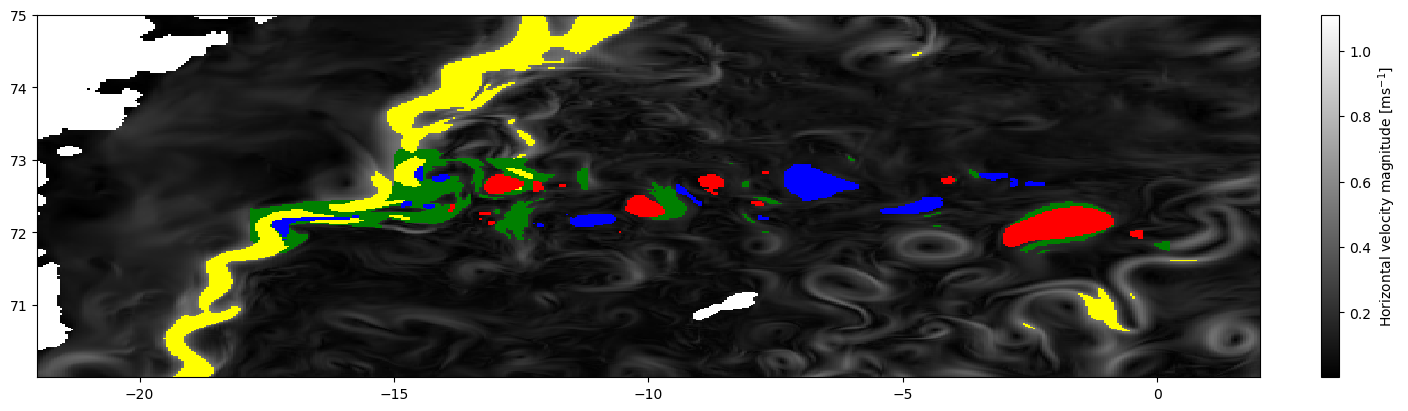

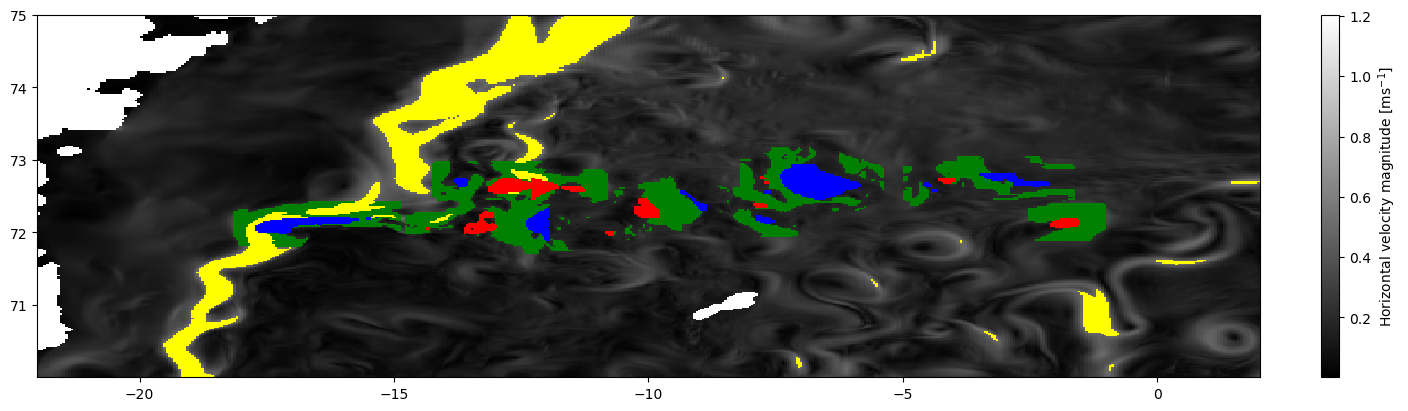

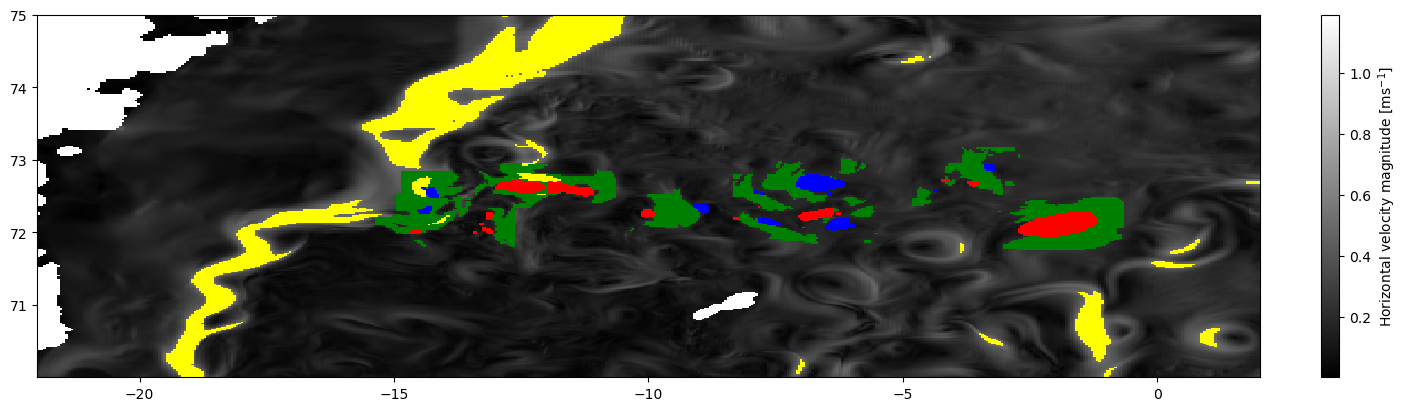

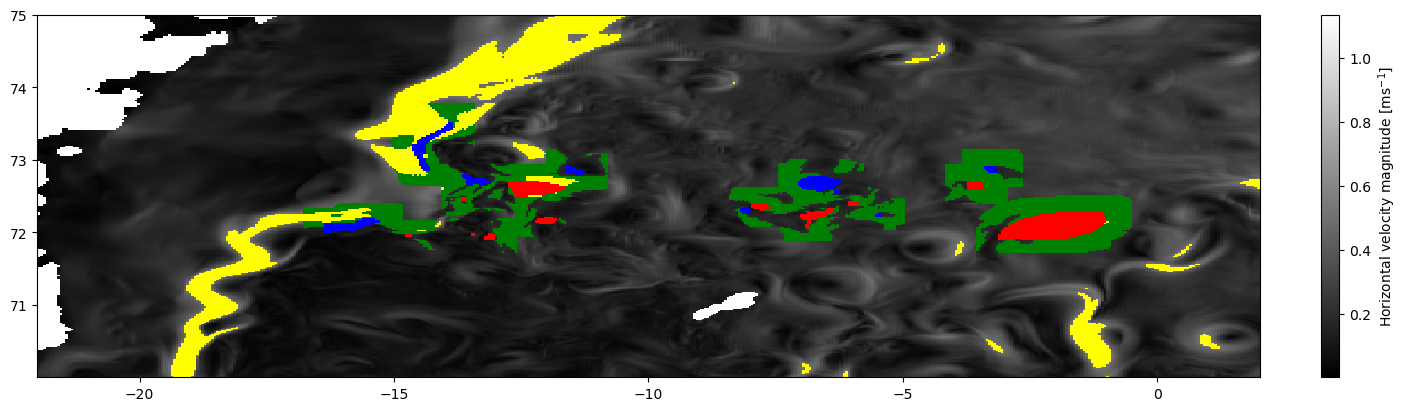

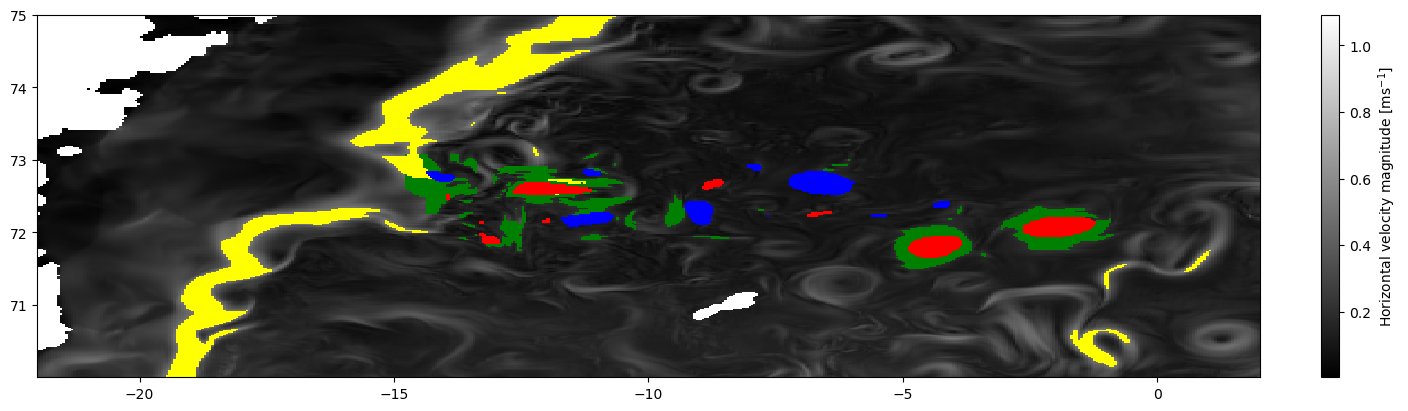

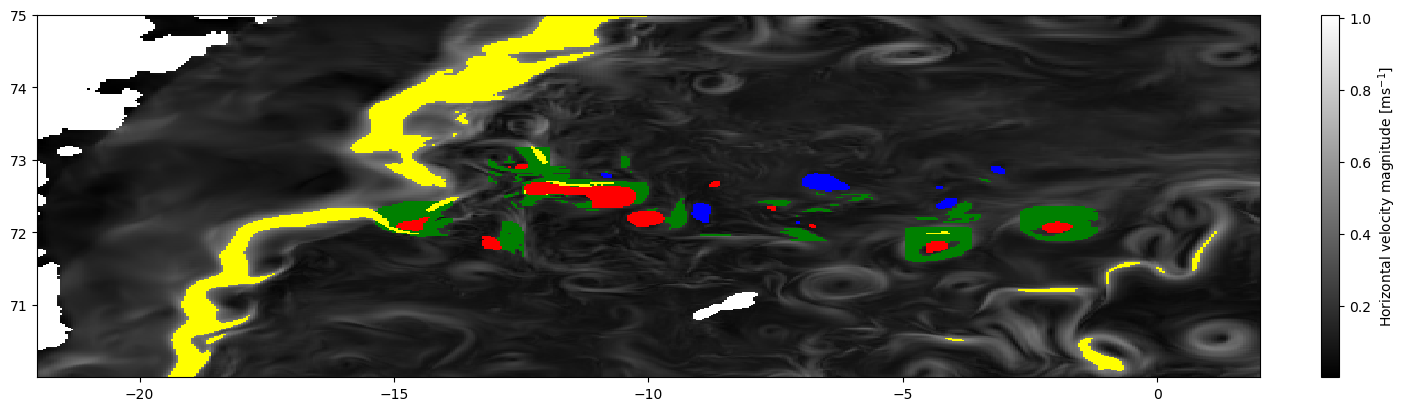

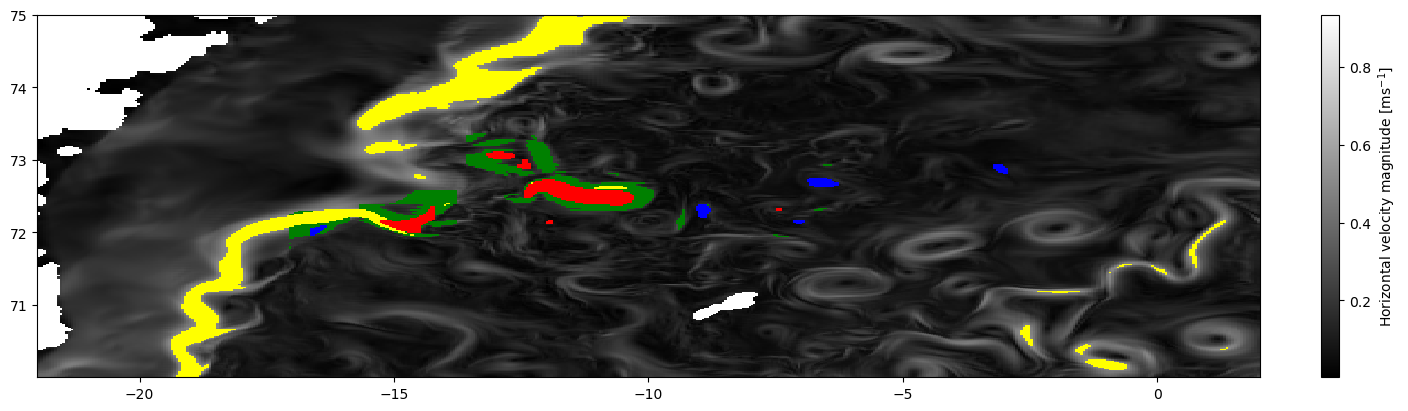

In [11]:
# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
for i in range(len(eddies_full.time)):
    fig, ax = plt.subplots(figsize=(14,4),layout='constrained')
    mesh = ax.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[i],cmap='binary_r')
    cbar = fig.colorbar(mesh)
    cbar.set_label('Horizontal velocity magnitude [ms$^{-1}$]')
    ax.pcolormesh(eddies_full.X,eddies_full.Y,eddies_full[i],cmap=cmap, norm=norm)
    plt.savefig(f'C:/Users/eirik/Master/Figures/FullEddyArea/{i}figFullEddy')